In [1]:
import sys
import datetime
import yaml
import pathlib

import math
import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import models
from torchvision import transforms

import hyperopt
from hyperopt import hp, fmin

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
sns.set()

import pytorch_wheel5.wheel5.logutils as logutils
from pytorch_wheel5.wheel5.organizer import Organizer
from pytorch_wheel5.wheel5.dataset import LMDBImageDataset, WrappingTransformDataset, split_indices
from pytorch_wheel5.wheel5.transforms import SquarePaddedResize
from pytorch_wheel5.wheel5.visualization import visualize_samples, visualize_cm, visualize_top_errors, visualize_errors
from pytorch_wheel5.wheel5.snapshotters import CheckpointSnapshotter, BestCVSnapshotter
from pytorch_wheel5.wheel5.model import fit, predict, score

from extra.data import load_aircraft_data

In [2]:
random_state = np.random.RandomState(42)

In [3]:
with open('config.yaml', 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.Loader)
    
    logutils.configure_logging(config['logging'])

    snapshot_root = config['paths']['snapshot_root']
    tensorboard_root = config['paths']['tensorboard_root']
    lmdb_dir = config['paths']['lmdb_dir']
    dataset_dir = config['paths']['dataset_dir']

In [4]:
df_images = load_aircraft_data(config['db'], 'aircraft_photos_snapshot', random_state)
df_images

,name,path
3574,A319,full/04a3c58c28d68a3370864c61fa8a76747bb7602a.jpg
4160,A320,full/96a88311717765fb5ef2b7e2f1f59eeb655caa94.jpg
381,B737-300,full/09b0b035a8e716233b63a4789b567933a817c939.jpg
4334,B737-400,full/65f339dbca25f0d050a55680efc73397499eb8ce.jpg
3844,MD-80,full/c41120ed3fe64bb40c6f2e5dccbc0ae6c8d5b927.jpg
...,...,...
3772,B777-300,full/12fdfbe9b403457ae457034b413154d7c36c4200.jpg
5191,A319,full/0e4e2b2f9ff70da429bd662841053a9c247fee34.jpg
5226,MD-11,full/6c0b47d1490bea84d8987539ae193d9977837c6c.jpg
5390,B747-400,full/01e645810cf85c356cbac4add5c9b514770dffbe.jpg


In [5]:
lmdb_dataset = LMDBImageDataset.cached(df_images, 
                                       image_dir=dataset_dir,
                                       lmdb_path=lmdb_dir, 
                                       prepare_transform=SquarePaddedResize(size=224))

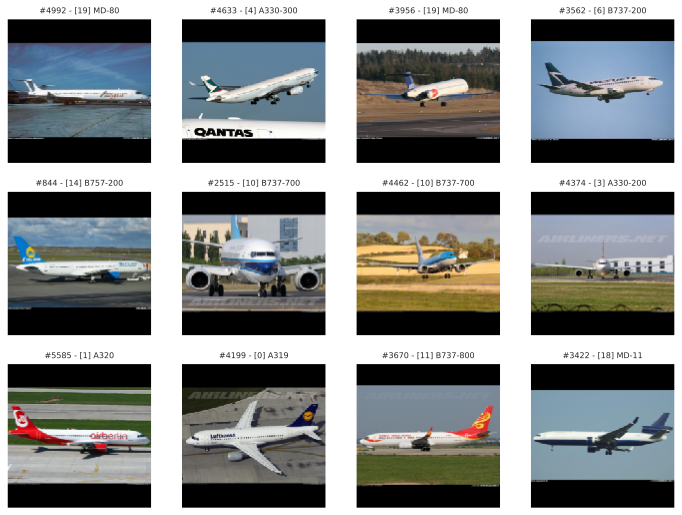

In [6]:
visualize_samples(lmdb_dataset, cols=4, rows=3)

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def transform_fn(arg):
    image, cls, name, index = arg
    return transform(image), cls, name, index

dataset = WrappingTransformDataset(
    wrapped=lmdb_dataset,
    transform_fn=transform_fn
)

In [8]:
indices = list(range(len(dataset)))

test_indices, nontest_indices = split_indices(indices, split=0.2, random_state=random_state)

pub_test_indices, priv_test_indices = split_indices(test_indices, split=0.5, random_state=random_state)
aux_indices, train_indices = split_indices(nontest_indices, split=0.3, random_state=random_state)
stack_indices, val_indices = split_indices(aux_indices, split=0.333, random_state=random_state)

pub_test_sampler = SubsetRandomSampler(pub_test_indices)
priv_test_sampler = SubsetRandomSampler(priv_test_indices)

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
stack_sampler = SubsetRandomSampler(stack_indices)

In [9]:
pub_test_loader = DataLoader(dataset, batch_size=256, sampler=pub_test_sampler, num_workers=4, pin_memory=True)
priv_test_loader = DataLoader(dataset, batch_size=256, sampler=priv_test_sampler, num_workers=4, pin_memory=True)

train_loader = DataLoader(dataset, batch_size=64, sampler=train_sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(dataset, batch_size=256, sampler=val_sampler, num_workers=4, pin_memory=True)
stack_loader = DataLoader(dataset, batch_size=256, sampler=stack_sampler, num_workers=4, pin_memory=True)

In [10]:
device = torch.device('cuda:0')

In [11]:
org = Organizer(snapshot_root, tensorboard_root, experiment='resnet18_hp3')

In [12]:
def fit_trial(config):    
    # Model preparation
    model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet18', pretrained=True)

    old_fc = model.fc
    model.fc = nn.Linear(in_features=old_fc.in_features, out_features=dataset.wrapped.classes())

    model.type(torch.cuda.FloatTensor)
    model.to(device)

    loss = nn.CrossEntropyLoss()

    params_old = list([param for name, param in model.named_parameters() if not name.startswith('fc.')])
    params_new = list([param for name, param in model.named_parameters() if name.startswith('fc.')])    
    optimizer_params = [
        {'params': params_old, 'lr': config['lrA'], 'weight_decay': config['wdA']},
        {'params': params_new, 'lr': config['lrB'], 'weight_decay': config['wdB']}
    ]
    optimizer = optim.AdamW(optimizer_params)
    
    
    # Training setup
    org_trial = org.new_trial(hparams=config)
    snapshot_dir = org_trial.snapshot_dir()
    tensorboard_dir = org_trial.tensorboard_dir()
    
    tb_writer = SummaryWriter(tensorboard_dir, max_queue=100, flush_secs=60)                
    
    metrics_df = fit(device, model, train_loader, val_loader, loss, optimizer,                                                                              
                     num_epochs=20,
                     snapshotter=[
                         CheckpointSnapshotter(snapshot_dir, frequency=10),
                         BestCVSnapshotter(snapshot_dir, metric_name='accuracy', asc=False, best=3),
                         BestCVSnapshotter(snapshot_dir, metric_name='loss', asc=True, best=3),
                     ], 
                     tb_writer=tb_writer, 
                     display_progress=False)
    
    
    # Reporting
    results = {
        'hp/best_val_acc': metrics_df['val_accuracy'].max(),
        'hp/best_val_loss': metrics_df['val_loss'].min(),
        'hp/final_val_acc': metrics_df['val_accuracy'].iloc[-1],
        'hp/final_val_loss': metrics_df['val_loss'].iloc[-1],
        
        'hp/best_train_acc': metrics_df['train_accuracy'].max(),
        'hp/best_train_loss': metrics_df['train_loss'].min(),
        'hp/final_train_acc': metrics_df['train_accuracy'].iloc[-1],
        'hp/final_train_loss': metrics_df['train_loss'].iloc[-1],
    }
    
    tb_writer.add_hparams(config, results)
    tb_writer.flush()
    
    return results['hp/best_val_loss']

space = {
    'lrA': hp.loguniform('lrA', math.log(1e-5), math.log(1)),
    'wdA': hp.loguniform('wdA', math.log(1e-4), math.log(1)),
    'lrB': hp.loguniform('lrB', math.log(1e-5), math.log(1)),
    'wdB': hp.loguniform('wdB', math.log(1e-4), math.log(1)),
}

best = fmin(fit_trial, space=space, algo=hyperopt.rand.suggest, max_evals=30)

  0%|          | 0/30 [00:00<?, ?it/s, best loss: ?]

Using cache found in /home/apollo/.cache/torch/hub/pytorch_vision_v0.4.2



  3%|▎         | 1/30 [02:00<58:15, 120.52s/it, best loss: 3.3170376420021057]

Using cache found in /home/apollo/.cache/torch/hub/pytorch_vision_v0.4.2



  7%|▋         | 2/30 [03:57<55:44, 119.43s/it, best loss: 3.01077139377594]  

Using cache found in /home/apollo/.cache/torch/hub/pytorch_vision_v0.4.2



  7%|▋         | 2/30 [09:37<2:14:38, 288.51s/it, best loss: 3.01077139377594]


KeyboardInterrupt: 

In [ ]:
org_trial = org.trial('lrA_0.00038961518646740266-lrB_0.0005887863025594929-wdA_0.01646022905613228-wdB_0.00039482653393852873')
snapshot_dir = org_trial.snapshot_dir()

snapshotter = BestCVSnapshotter(snapshot_dir, metric_name='accuracy', asc=False, best=3)
bestcv_snapshots_df = snapshotter.list_snapshots()
filename = bestcv_snapshots_df.iloc[0]['filename']

snapshotter.load_snapshot(filename)

In [ ]:
FinalSnapshotter(snapshot_dir).list_snapshots()

In [ ]:
PeriodicSnapshotter(snapshot_dir, frequency=10).list_snapshots()

In [ ]:
metrics_df

In [ ]:
results = predict(device, model, val_loader)

y_true = results['y']
y_pred = results['y_hat']
indices = results['indices']

In [ ]:
score(device, model, test_loader, loss)

In [ ]:
classes = val_loader.dataset.wrapped.name_by_idx
visualize_cm(classes, y_true, y_pred)

In [ ]:
visualize_top_errors(classes, y_true, y_pred, indices, lmdb_dataset)

In [ ]:
visualize_errors(classes, y_true, y_pred, 'B737-400', 'A320', indices, lmdb_dataset)